In [460]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from wordcloud import WordCloud
from matplotlib_venn import venn2
import nltk
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
nltk.download('all')

sns.set_palette(sns.color_palette("deep"))

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/arinaruck/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/arinaruck/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/arinaruck/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/arinaruck/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/arinaruck/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Down

In [478]:
data_folder = Path('data/')
pickle_folder = data_folder / 'pickles'
imdb_folder = data_folder / 'IMDB'
image_folder = Path('Images/')

## Overview of terms related to characters of different genders

### Preparing the relevant data

Let's look at the verbs describing characters in movies. To analyse the dynamics in portraying different characters we need the biometrics info as well as the year of movie release.
For that we need to merge the characters to corresponding actors and gather all relevant data.

In [479]:
with open(pickle_folder / 'character_verbs_3.p', 'rb') as f:
    characters_desc = pickle.load(f)

with open(pickle_folder / 'characters.p', 'rb') as f:
    characters = pickle.load(f)
    characters.drop(columns=['wikipedia_id'], inplace=True)

with open(pickle_folder / 'movies.p', 'rb') as f:
    movies = pickle.load(f)

In [480]:
characters_desc.sample(10)

movie          character  \
wiki_id_character_name                                   
497081_Sarah                 497081              Sarah   
27279709_Dodge Landon      27279709       Dodge Landon   
24200166_Insp. Ramage      24200166       Insp. Ramage   
92703_Ida Carmody             92703        Ida Carmody   
4102452_Kaushalya           4102452          Kaushalya   
5191439_Leann Cole          5191439         Leann Cole   
15656621_Han Lue           15656621            Han Lue   
600194_Slash                 600194              Slash   
1011468_Barbara Geoghegan   1011468  Barbara Geoghegan   
431562_Leslie                431562             Leslie   

                                                                  agent_word  \
wiki_id_character_name                                                         
497081_Sarah                                                             NaN   
27279709_Dodge Landon                                             [attempts]   
24200166_Insp. Ramage                                                    NaN   
92703_Ida Carmody          [want, convinces, enjoys, saving, persuades, c...   
4102452_Kaushalya               [heard, tells, insists, rejects, humiliates]   
5191439_Leann Cole                                                       NaN   
15656621_Han Lue                                                         NaN   
600194_Slash                                                             NaN   
1011468_Barbara Geoghegan                                                NaN   
431562_Leslie                                                  [join, grows]   

                                                                 agent_lemma  \
wiki_id_character_name                                                         
497081_Sarah                                                             NaN   
27279709_Dodge Landon                                              [attempt]   
24200166_Insp. Ramage                                                    NaN   
92703_Ida Carmody          [want, convince, enjoy, save, persuade, convin...   
4102452_Kaushalya                    [hear, tell, insist, reject, humiliate]   
5191439_Leann Cole                                                       NaN   
15656621_Han Lue                                                         NaN   
600194_Slash                                                             NaN   
1011468_Barbara Geoghegan                                                NaN   
431562_Leslie                                                   [join, grow]   

                                           patient_word  \
wiki_id_character_name                                    
497081_Sarah                                        NaN   
27279709_Dodge Landon                               NaN   
24200166_Insp. Ramage                               NaN   
92703_Ida Carmody                              [breach]   
4102452_Kaushalya          [makes, reminds, reminisces]   
5191439_Leann Cole                                  NaN   
15656621_Han Lue                                    NaN   
600194_Slash                                        NaN   
1011468_Barbara Geoghegan                           NaN   
431562_Leslie                              [restaurant]   

                                       patient_lemma attribute_word  \
wiki_id_character_name                                                
497081_Sarah                                     NaN            NaN   
27279709_Dodge Landon                            NaN            NaN   
24200166_Insp. Ramage                            NaN            NaN   
92703_Ida Carmody                           [breach]            NaN   
4102452_Kaushalya          [make, remind, reminisce]            NaN   
5191439_Leann Cole                               NaN            NaN   
15656621_Han Lue                                 NaN            NaN   
600194_Slash                                     NaN           

In [481]:
characters = characters.merge(
    movies[['wikipedia_id', 'title']], 
    left_on='movie_wiki_id', right_on='wikipedia_id', how='left')
characters.drop(columns=['wikipedia_id'], inplace=True)
characters.rename(columns={'title': 'movie_title'}, inplace=True)
characters.head()  

movie_wiki_id movie_freebase_id  release_date_cmu  \
0         975900         /m/03vyhn              2001   
1         975900         /m/03vyhn              2001   
2         975900         /m/03vyhn              2001   
3         975900         /m/03vyhn              2001   
4         975900         /m/03vyhn              2001   

               character_name          actor_name  height  birth_cmu  \
0                    Akooshay      Wanda De Jesus   1.620     1958.0   
1  Lieutenant Melanie Ballard  Natasha Henstridge   1.780     1974.0   
2         Desolation Williams            Ice Cube   1.727     1969.0   
3          Sgt Jericho Butler       Jason Statham   1.750     1967.0   
4             Bashira Kincaid         Clea DuVall   1.650     1977.0   

   birth_wd  birth_imdb  combined_birth  ...  ethnicity_wd combined_ethnicity  \
0    1958.0      1958.0          1958.0  ...           NaN                NaN   
1    1974.0      1974.0          1974.0  ...           NaN                NaN   
2    1969.0      1969.0          1969.0  ...           NaN  African Americans   
3    1967.0      1967.0          1967.0  ...           NaN                NaN   
4    1977.0      1977.0          1977.0  ...           NaN                NaN   

  freebase_character_id freebase_actor_id wikidata_actor_id actor_imdb_id  \
0            /m/0bgcj3x        /m/03wcfv7          Q1873468     nm0208962   
1            /m/0bgchn4         /m/0346l4           Q230527     nm0000449   
2            /m/0bgchn_        /m/01vw26l           Q173637     nm0001084   
3            /m/0bgchnq         /m/034hyc           Q169963     nm0005458   
4            /m/0bgchp9         /m/01y9xg           Q233347     nm0245112   

  combined_release_year movie_metric actor_metric     movie_title  
0                2001.0     2.360202     3.680168  Ghosts of Mars  
1                2001.0     2.360202     8.613544  Ghosts of Mars  
2                2001.0     2.360202    16.246636  Ghosts of Mars  
3                2001.0     2.360202    18.203484  Ghosts of Mars  
4                2001.0     2.360202    14.419565  Ghosts of Mars  

[5 rows x 25 columns]

Let's approximate the age of the actors by substracting their date of birth from the movie release date

We would acquire the biometric information for the characters with description and process the missing values:

In [482]:
characters_keep_columns = ['movie_wiki_id', 'character_name', 'combined_gender', 
                           'combined_ethnicity', 'combined_release_year', 'combined_birth']
characters_desc['movie'] = pd.to_numeric(characters_desc['movie'])
characters_with_description = characters_desc.merge(characters[characters_keep_columns], 
                                                              right_on=['movie_wiki_id', 'character_name'], 
                                                              left_on=['movie', 'character'],
                                                              how='left')
                                                              
characters_with_description['patient_lemma'].fillna('', inplace=True)
characters_with_description['agent_lemma'].fillna('', inplace=True)  
characters_with_description['attribute_lemma'].fillna('', inplace=True)                                                   
characters_with_description['age'] = characters_with_description['combined_release_year'] - characters_with_description['combined_birth']
characters_with_description['decade'] = characters_with_description['combined_release_year'].apply(lambda x: x // 10 * 10)
characters['decade'] = characters['combined_release_year'].apply(lambda x: x // 10 * 10)

characters_with_description

movie           character                   agent_word  \
0       10000053             La Bete                          NaN   
1       10002175      Melora Kendall                          NaN   
2       10002175      Bobbie Chester                          NaN   
3       10004330         Pigeon Lane              [shoots, kills]   
4       10004330  Lt. Col. Gilfillan  [warns, recounts, receives]   
...          ...                 ...                          ...   
142376     99984              Miguel                          NaN   
142377     99984             Charlie                          NaN   
142378     99984               Ricky                          NaN   
142379     99984          Senora Mia                          NaN   
142380     99984              Xavier                          NaN   

                     agent_lemma patient_word patient_lemma attribute_word  \
0                                         NaN                          NaN   
1                                         NaN                          NaN   
2                                         NaN                          NaN   
3                  [shoot, kill]     [timers]       [timer]            NaN   
4       [warn, recount, receive]          NaN                          NaN   
...                          ...          ...           ...            ...   
142376                                    NaN                          NaN   
142377                                    NaN                          NaN   
142378                                    NaN                          NaN   
142379                                    NaN                          NaN   
142380                                    NaN                          NaN   

       attribute_lemma  movie_wiki_id      character_name combined_gender  \
0                            10000053             La Bete            male   
1                            10002175      Melora Kendall          female   
2                            10002175      Bobbie Chester          female   
3                            10004330         Pigeon Lane            male   
4                            10004330  Lt. Col. Gilfillan            male   
...                ...            ...                 ...             ...   
142376                          99984              Miguel            male   
142377                          99984             Charlie            male   
142378                          99984               Ricky            male   
142379                          99984          Senora Mia          female   
142380                          99984              Xavier            male   

         combined_ethnicity  combined_release_year  combined_birth   age  \
0            English people                 1966.0          1938.0  28.0   
1                       NaN                 2005.0          1980.0  25.0   
2                       NaN                 2005.0          1982.0  23.0   
3       Ukrainian Americans                 1950.0          1919.0  31.0   
4                       NaN                 1950.0          1917.0  33.0   
...                     ...                    ...             ...   ...   
142376                  NaN                 1982.0          1968.0  14.0   
142377                  NaN                 1982.0          1969.0  13.0   
142378                  NaN                 1982.0          1967.0  15.0   
142379                  NaN                 1982.0          1943.0  39.0   
142380                  NaN                 1982.0          1968.0  14.0   

        decade  
0       1960.0  
1       2000.0  
2       2000.0  
3       1950.0  
4       1950.0  
...        ...  
142376  1980.0  
142377  1980.0  
142378  1980.0  
142379  1980.0  
142380  1980.0  

[142381 rows x 16 columns]

We would consider the characters, who have been mentioned in movie plots as the main characters, since they have been important enough to get mentioned in the condenced description of the movie

In [483]:
from string import punctuation
import re 

EXCLUDE_CHARS = set(punctuation).union(set('’'))
punct = re.compile(fr'[{re.escape("".join(EXCLUDE_CHARS))}]')

def clean_line(line):
    line = line.strip().lower()
    line = re.sub(punct, ' ', line)
    line = re.sub(r'\s+', ' ', line)
    return line

In [484]:
with open('data/MovieSummaries/plot_summaries.txt', 'r') as f:
    wiki_ids = []
    clean_lines = []
    for line in tqdm(f):
        wiki_id, plot = line.split('\t')
        line = clean_line(plot)
        clean_lines.append(line + '\n')
        wiki_ids.append(int(wiki_id))
    
plots_df = pd.DataFrame({'wiki_id': wiki_ids, 'plot': clean_lines})
pickle.dump(plots_df, open(pickle_folder / 'plots_df.p', 'wb'))
print(f"There are {len(wiki_ids)} plot summaries, accesible")
    
# Let's save the processed lines for later   
with open('data/MovieSummaries/plot_summaries_clean.txt', 'w') as f:
    f.writelines(clean_lines)

0it [00:00, ?it/s]

There are 42306 plot summaries, accesible


In [485]:
characters_from_movies_with_plots = characters[characters['movie_wiki_id'].isin(plots_df['wiki_id'])]
characters_with_description['has_description'] = ~characters_with_description.agent_word.isna() | \
                                                 ~characters_with_description.patient_word.isna() | \
                                                 ~characters_with_description.attribute_word.isna()
characters_with_description = characters_with_description[characters_with_description['has_description']]
common_movies = set(characters_from_movies_with_plots['movie_wiki_id'].unique()).intersection(set(characters_with_description['movie'].unique()))
print(f"There are {len(common_movies)} movies with known characters and descriptions")
characters_with_description = characters_with_description[characters_with_description['movie'].isin(common_movies)]
characters_from_movies_with_plots = characters_from_movies_with_plots[characters_from_movies_with_plots['movie_wiki_id'].isin(common_movies)]


There are 18748 movies with known characters and descriptions


Let's look at the amount of datapoints we have for each decade:

In [486]:
decade_counts = characters_with_description.groupby(by=['decade', 'combined_gender']).count()
decade_counts = decade_counts.reset_index()
decade_counts = decade_counts[['decade', 'combined_gender', 'character']]
# we consider only 2 genders for the overview since only they are present in the most of the decades
# we will consider all genders in the more in depth analysis
decade_counts = decade_counts[decade_counts['combined_gender'].isin(['male', 'female'])]
fig = px.line(decade_counts, x='decade', y='character', color='combined_gender', markers=True,
    labels=
        {
            "decade": "Decade",
            "combined_gender": "Gender",
            "character": "Number of Characters"
        },
    title="Number of Characters per Decade",
    )
fig.show()
fig.write_html("docs/_includes/characters_per_decade.html")

We can see that before the 1930s there were not sufficient nubmer of characters with descriptions in our data, so we would shrink the period we are considering to 1930-2010.

The significant drop in 2010 can be explained by the fact that not all movies for the decade were created at the time of data collection.

In [487]:
START_DECADE = 1930
END_DECADE = 2010
DECADES = np.arange(START_DECADE, END_DECADE + 1, 10)
print(f"Considering decades from {START_DECADE} to {END_DECADE}")


Considering decades from 1930 to 2010


In [488]:
n_characters_with_descriptions_per_movie = characters_with_description.groupby(['movie', 'combined_gender']).size().rename('n_characters_with_descriptions').reset_index()
n_characters_per_movie = characters_from_movies_with_plots.groupby(['movie_wiki_id', 'combined_gender']).size().rename('n_characters').reset_index()
gender_wise_character_stats = pd.merge(n_characters_per_movie, n_characters_with_descriptions_per_movie, how='inner', right_on='movie', left_on='movie_wiki_id')
gender_wise_character_stats.drop(columns=['combined_gender_y', 'movie'], inplace=True)
gender_wise_character_stats.rename(columns={'combined_gender_x': 'gender'}, inplace=True)
male_character_stats = gender_wise_character_stats[gender_wise_character_stats['gender'] == 'male']
female_character_stats = gender_wise_character_stats[gender_wise_character_stats['gender'] == 'female']

In [489]:
characters_with_description['combined_gender'].value_counts()

male           40113
female         22522
non-binary        47
genderfluid       29
trans woman        4
trans man          2
Name: combined_gender, dtype: int64

In [490]:
full_df = pd.DataFrame()
for decade in range(START_DECADE, END_DECADE, 10):
    decade_chars_with_desc = characters_with_description[characters_with_description['decade'] == decade]
    decade_chars = characters_from_movies_with_plots[characters_from_movies_with_plots['decade'] == decade]
    n_characters_with_descriptions_per_movie = decade_chars_with_desc.groupby(['movie', 'combined_gender']).size().rename('n_characters').reset_index()
    n_characters_with_descriptions_per_movie['type'] = 'Main characters'
    n_characters_per_movie = decade_chars.groupby(['movie_wiki_id', 'combined_gender']).size().rename('n_characters').reset_index()
    n_characters_per_movie['type'] = 'All characters'
    gender_wise_character_stats = pd.concat([n_characters_per_movie, n_characters_with_descriptions_per_movie])
    gender_wise_character_stats.rename(columns={'combined_gender': 'gender'}, inplace=True)
    gender_wise_character_stats = gender_wise_character_stats[gender_wise_character_stats['gender'].isin(['male', 'female'])]
    gender_wise_character_stats["decade"] = decade
    full_df = pd.concat([full_df, gender_wise_character_stats])

full_df['gender'] = full_df['gender'].str.capitalize()
fig = px.histogram(full_df, x="n_characters", facet_col="gender", animation_frame="decade", color='type', 
                  color_discrete_sequence=['green', 'purple'],     
                  labels=
                    {
                        "n_characters": "Character number",
                        "type": "Character type",
                        "decade": "Decade",
                    },)
fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[1]))
fig.update_traces(opacity=0.3)
fig.update_layout(
    title=f"All and Main Characters Per Decade",
    legend_title="Gender",
)
fig.show()
fig.write_html("docs/_includes/main_characters_per_decade.html")

From the plots we can see that even though the number of male characters if consistently higher than the number of female characters for each decade, we can notice that starting from the 70s the amount of main characters is on par between genders.

### Descriptive statistics

In [491]:
# taking a subset of the data of interes
characters_with_description = characters_with_description[characters_with_description['decade'] >= START_DECADE]
characters_with_description = characters_with_description[characters_with_description['decade'] <= END_DECADE]
characters_with_description.rename(columns={'combined_gender': 'gender'}, inplace=True)
characters_with_description = characters_with_description[characters_with_description['gender'].isin(['male', 'female'])]


Next, we would like to see the number of unique terms used to describe characters of each gender.

In [493]:
def aggregate_into_set(lemma_lists):
    lemma_set = set(sum(lemma_lists, []))
    return lemma_set
    
def get_stats(bootstraped):
    mean, low, high = bootstraped.mean(axis=0),  np.quantile(bootstraped, q=0.025, axis=0), np.quantile(bootstraped, q=0.975, axis=0)
    # separating genders
    mean = mean.reshape(2, -1)
    low = low.reshape(2, -1)
    high = high.reshape(2, -1)
    return mean, low, high

def plot_decade_lemmas(df, lemma_type):
    df = df[df[f'{lemma_type}_lemma'].str.len() > 0]

    n_samples = 1000
    n_uniques = np.zeros((n_samples, len(DECADES) * 2))
    n_uniques_per_character = np.zeros((n_samples, len(DECADES) *  2))

    for i in range(n_samples):
        df_sample = df.sample(frac=1, replace=True)
        decade_lemmas = df_sample[['decade', 'gender', f'{lemma_type}_lemma', 'character']].groupby(by=['decade', 'gender']).agg(
            {f'{lemma_type}_lemma': aggregate_into_set, 'character': 'count'})
        decade_lemmas = decade_lemmas.reset_index()
        decade_lemmas['n_unique'] = decade_lemmas[f'{lemma_type}_lemma'].str.len()
        decade_lemmas['unique_per_character'] = decade_lemmas['n_unique'] / decade_lemmas['character']
        decade_lemmas.sort_values(by=['gender', 'decade'], inplace=True)
        n_uniques[i, :] = decade_lemmas['n_unique'].values
        n_uniques_per_character[i, :] = decade_lemmas['unique_per_character'].values

    n_unique_mean, n_unique_low, n_unique_high = get_stats(n_uniques)
    n_unique_per_char_mean, n_unique_per_char_low, n_unique_per_char_high = get_stats(n_uniques_per_character)
    display(decade_lemmas.tail())

    fig = make_subplots(rows=1, cols=2, subplot_titles=(f'Unique {lemma_type.capitalize()}s', \
                                                        f'Unique {lemma_type.capitalize()}s per Character'))

    for i, (label, col) in enumerate([('Female', 'red'), ('Male', 'blue')]):
        fig.add_trace(
                go.Scatter(
                    x=DECADES,
                    y=n_unique_mean[i],
                    name=label,
                    line={'color':col},
                    error_y=dict(
                        type='data',
                        symmetric=False,
                        array=n_unique_high[i] - n_unique_mean[i],
                        arrayminus=n_unique_mean[i] - n_unique_low[i],
                    ),
                ),
                row=1, col=1)

        fig.add_trace(
            go.Scatter(
                x=DECADES,
                y=n_unique_per_char_mean[i],
                line={'color':col},
                showlegend=False,
                error_y=dict(
                    type='data',
                    symmetric=False,
                    array=n_unique_per_char_high[i] - n_unique_per_char_mean[i],
                    arrayminus=n_unique_per_char_mean[i] - n_unique_per_char_low[i],
                ),
            ), 
            row=1, col=2
        )
    fig.update_xaxes(title_text="Decade", row=1, col=1)
    fig.update_xaxes(title_text="Decade", row=1, col=2)
    fig.show()
    fig.write_html(f"docs/_includes/unique_{lemma_type}s.html")
    

In [494]:
plot_decade_lemmas(characters_with_description, 'attribute')

decade gender                                    attribute_lemma  \
9   1970.0   male  {unmoved, mad, youthful, rich, happy, gentle, ...   
11  1980.0   male  {ambitious, unchanged, mad, unloved, comfortab...   
13  1990.0   male  {brilliant, stuck, regretful, happy, gentle, s...   
15  2000.0   male  {empathetic, blunt, longer, comfortable, grump...   
17  2010.0   male  {distressed, modern, mad, inconspicuous, cluel...   

    character  n_unique  unique_per_character  
9         363       163              0.449036  
11        533       210              0.393996  
13       1126       324              0.287744  
15       2181       537              0.246217  
17        616       214              0.347403

We see that the number of attributes is lower for female characters than for the male ones. 
Nethertheless, the number of unique terms per character is consistently higher for females than for males.
This can mean that even though there are less female characters they are more developed and thought-through.
Interestingly enough, the general trend of the number of attributes per character is decreasing. So there are more characters in the movies, but they might possess the same set of typical qualities.

### Initial qualitive analysis

In [182]:
from collections import Counter

def join_lemmas(column):
    return (column.apply(lambda x:' '.join(x)) + ' ').sum()

def lemma_frqs(column):
    all_verbs = sum(column[column != ''], [])
    freqs = Counter(all_verbs)
    return freqs

In [183]:
patient_freqs = lemma_frqs(characters_with_description['patient_lemma'])
agent_freqs = lemma_frqs(characters_with_description['agent_lemma'])
attribute_freqs = lemma_frqs(characters_with_description['attribute_lemma'])

Let's have a look at the overall distribution of the character terms and attributes:

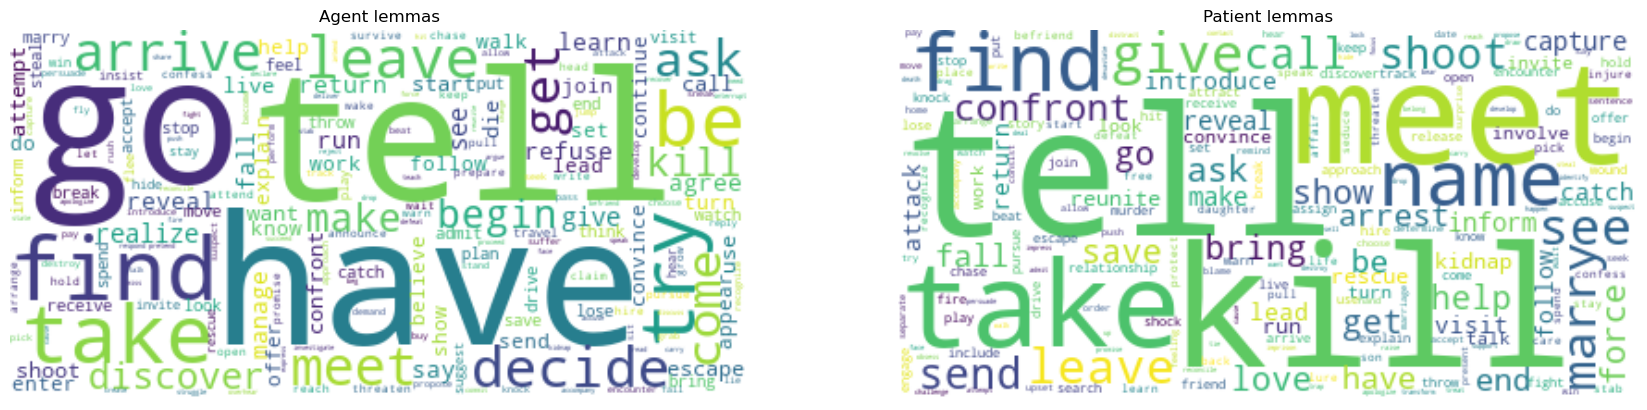

In [495]:
wordcloud_agent = WordCloud(background_color="white", margin=1).generate_from_frequencies(agent_freqs)
wordcloud_patient = WordCloud(background_color="white", margin=1).generate_from_frequencies(patient_freqs)

fig, axes = plt.subplots(1, 2, figsize=(21, 9))

axes[0].imshow(wordcloud_agent, interpolation='bilinear')
axes[0].set_title('Agent lemmas')
axes[0].axis("off")
axes[1].imshow(wordcloud_patient, interpolation='bilinear')
axes[1].set_title('Patient lemmas')
axes[1].axis("off")
plt.show()

We can see, that generally the agent and patient terms have a similar distribution.

In [496]:
def get_unique_verbs_and_freqs(column):
    freqs = lemma_frqs(column)
    uniq_verbs = set(freqs.keys())
    return freqs, uniq_verbs

def get_subset_freqs(default_freqs, subset):
    subset_freqs = {k: default_freqs[k] for k in subset}
    return subset_freqs

In [497]:
def get_gender_specific_stats(df, lemma_type, n_iters=1000):

    df_non_empty = df[df[f'{lemma_type}_lemma'].str.len() > 0]

    female_lemmas = sum(df_non_empty[df_non_empty['gender'] == 'female'][f'{lemma_type}_lemma'].values.tolist(), [])
    male_lemmas = sum(df_non_empty[df_non_empty['gender'] == 'male'][f'{lemma_type}_lemma'].values.tolist(), [])

    female_uniques = []
    male_uniques = []
    for i in range(n_iters):
        female_lemmas_i = np.random.choice(female_lemmas, size=len(female_lemmas), replace=True)
        male_lemmas_i = np.random.choice(male_lemmas, size=len(female_lemmas), replace=True)

        female_terms = set(female_lemmas_i)
        male_terms = set(male_lemmas_i)

        female_only_terms = female_terms - male_terms
        male_only_terms = male_terms - female_terms

        female_uniques.append(len(female_only_terms))
        male_uniques.append(len(male_only_terms))
    female_mean, (female_low, female_high) = np.mean(female_uniques), np.quantile(female_uniques, q=[0.025, 0.975])
    male_mean, (male_low, male_high) = np.mean(male_uniques), np.quantile(male_uniques, q=[0.025, 0.975])
    return [female_mean, female_mean - female_low, female_high - female_mean], \
           [male_mean, male_mean - male_low, male_high - male_mean]

In [498]:
female_specific_verbs_n_stats = []
male_specific_verbs_n_stats = []
lemma_type = 'attribute'

for i, decade in enumerate(DECADES):
    decade_descriptions = characters_with_description[characters_with_description['decade'] == decade]

    female_agent_freqs, female_agent_verbs = get_unique_verbs_and_freqs(decade_descriptions[
            decade_descriptions['gender'] == 'female'][f'{lemma_type}_lemma'])
    male_agent_freqs, male_agent_verbs = get_unique_verbs_and_freqs(decade_descriptions[
        decade_descriptions['gender'] == 'male'][f'{lemma_type}_lemma'])

    female_only_agent_verbs = female_agent_verbs - male_agent_verbs
    male_only_agent_verbs = male_agent_verbs - female_agent_verbs

    female_only_agent_freqs = get_subset_freqs(female_agent_freqs, female_only_agent_verbs)
    male_only_agent_freqs = get_subset_freqs(male_agent_freqs, male_only_agent_verbs)

    f_stats, m_stats = get_gender_specific_stats(decade_descriptions, lemma_type, n_iters=1000)
    female_specific_verbs_n_stats.append(f_stats)
    male_specific_verbs_n_stats.append(m_stats)

In [499]:
female_specific_verbs_n_stats = np.array(female_specific_verbs_n_stats)
male_specific_verbs_n_stats = np.array(male_specific_verbs_n_stats)

fig = go.Figure(data=[go.Scatter(
        x=DECADES,
        y=female_specific_verbs_n_stats[:, 0],
        name='Female',
        line={'color':'red'},
        error_y=dict(
            type='data',
            symmetric=False,
            array=female_specific_verbs_n_stats[:, 2],
            arrayminus=female_specific_verbs_n_stats[:, 1],
        )), 
        go.Scatter(
        x=DECADES,
        y=male_specific_verbs_n_stats[:, 0],
        line={'color': 'blue'},
        name='Male',
        error_y=dict(
            type='data',
            symmetric=False,
            array=male_specific_verbs_n_stats[:, 2],
            arrayminus=male_specific_verbs_n_stats[:, 1],
            ),
)],)
fig.update_layout(
    title=f"Number of gender-specific {lemma_type} terms in plot summaries (±95% CI)",
    xaxis_title="Decade",
    legend_title="Gender",
)
fig.show()

We can also see that the number of gender-specific verbs for women is consistently lower than for men. 
Let's look at the shares on the example of one decade:

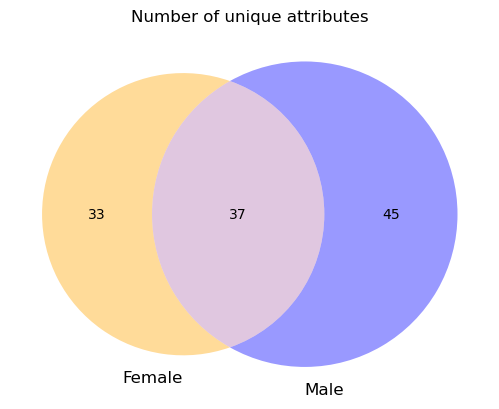

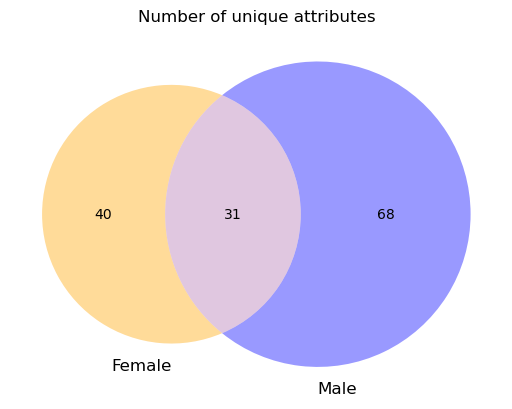

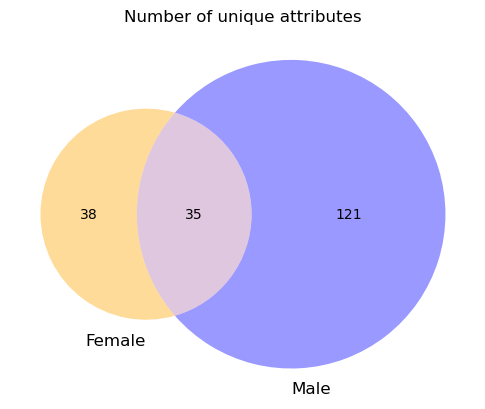

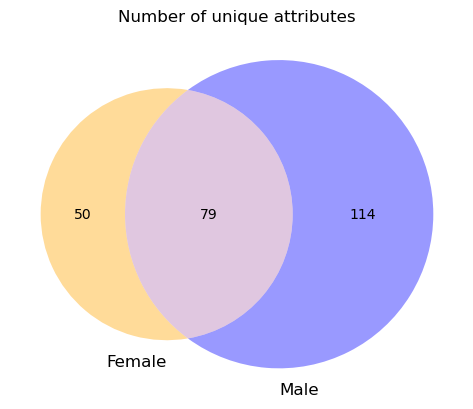

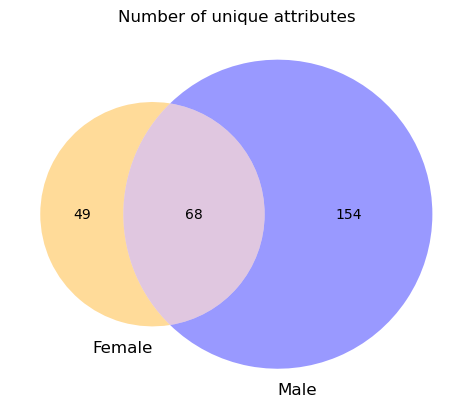

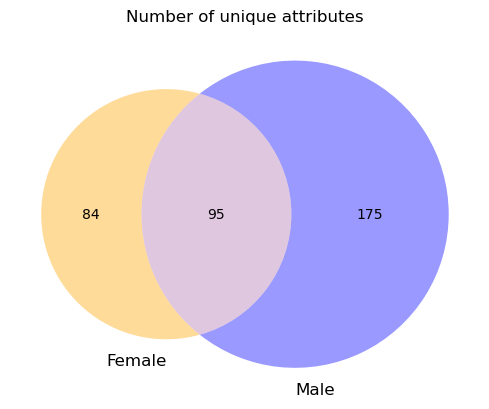

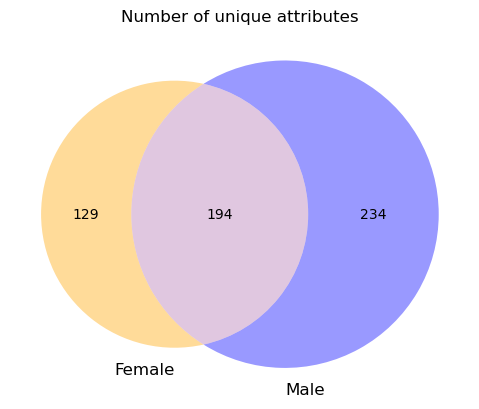

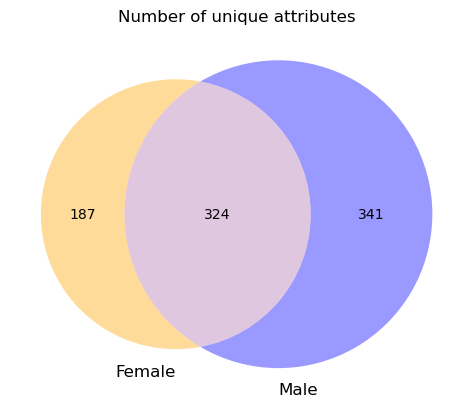

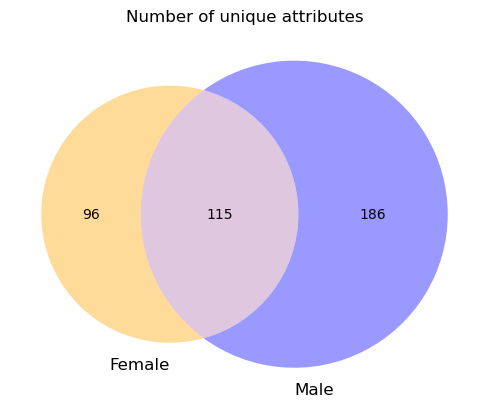

In [500]:
for decade in DECADES:
    decade_movies = characters_with_description[characters_with_description['decade'] == decade]

    _, female_attributes = get_unique_verbs_and_freqs(decade_movies[decade_movies['gender'] == 'female']['attribute_lemma'])
    _, male_attributes = get_unique_verbs_and_freqs(decade_movies[decade_movies['gender'] == 'male']['attribute_lemma'])
    female_attribute_vocabulary = female_attributes - male_attributes
    male_attribute_vocabulary = male_attributes - female_attributes
    common_attribute_vocabulary = female_attributes.intersection(male_attributes)

    venn2(subsets = (len(female_attribute_vocabulary), len(male_attribute_vocabulary), len(common_attribute_vocabulary)), set_labels = ('Female', 'Male'), set_colors=('orange', 'blue'))
    plt.title('Number of unique attributes')
    plt.show()

### Attribute wordclouds

In [501]:
from PIL import Image
import cv2 as cv

In [502]:
# converting images to wordcloud masks

def transparent_png_to_mask(filename):
    image_4channel = cv.imread(filename, cv.IMREAD_UNCHANGED)
    alpha_channel = image_4channel[:,:,3]
    rgb_channels = image_4channel[:,:,:3]

    # White Background Image
    white_background_image = np.ones_like(rgb_channels, dtype=np.uint8) * 255

    # Alpha factor
    alpha_factor = alpha_channel[:,:,np.newaxis].astype(np.float32) / 255.0
    alpha_factor = np.concatenate((alpha_factor,alpha_factor,alpha_factor), axis=2)

    # Transparent Image Rendered on White Background
    base = rgb_channels.astype(np.float32) * alpha_factor
    white = white_background_image.astype(np.float32) * (1 - alpha_factor)
    final_image = base + white
    mask = cv.floodFill(final_image, None, (0, 0), 255)[1]
    mask = ((mask[:,:,0] != 255).astype(int) + (mask[:,:,2] == 255).astype(int)) == 0
    return mask.astype(np.uint8)

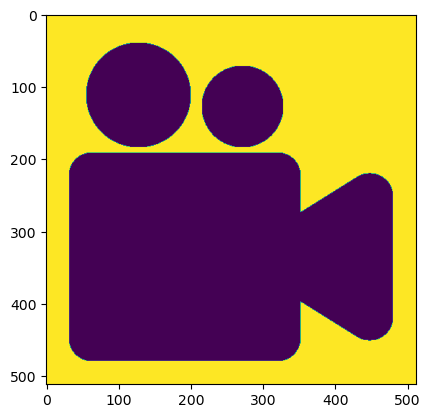

In [503]:
mask = transparent_png_to_mask(str(image_folder / "video-camera.png")) * 255
plt.imsave(image_folder /'camera_mask.png', mask, cmap='gray')
plt.imshow(mask)

To get an idea of the kind of data we are dealing with, we look at the wordclouds of unique attributes for each gender and decade.

In [512]:
mask = np.array(Image.open(image_folder / 'camera_mask.png'))
wcs = []
for i, decade in enumerate(DECADES):
    decade_descriptions = characters_with_description[characters_with_description['decade'] == decade]

    female_att_freqs, female_atts = get_unique_verbs_and_freqs(decade_descriptions[
            decade_descriptions['gender'] == 'female']['attribute_lemma'])
    male_att_freqs, male_atts = get_unique_verbs_and_freqs(decade_descriptions[
        decade_descriptions['gender'] == 'male']['attribute_lemma'])

    female_only_atts = female_atts - male_atts
    male_only_atts = male_atts - female_atts

    female_only_att_freqs = get_subset_freqs(female_att_freqs, female_only_atts)
    male_only_att_freqs = get_subset_freqs(male_att_freqs, male_only_atts)

    wordcloud_female_only = WordCloud(background_color="white", margin=1, mask=mask, 
                                    contour_width=3, colormap='RdPu', contour_color='grey').generate_from_frequencies(female_only_att_freqs)
    wordcloud_male_only = WordCloud(background_color="white", 
                                margin=1, mask=mask, 
                                contour_width=3, colormap='GnBu', contour_color='grey').generate_from_frequencies(male_only_att_freqs)
    wcs.append([wordcloud_female_only.to_array(), wordcloud_male_only.to_array()])

genders = ['Female', 'Male']
wcs = np.array(wcs)
fig = px.imshow(wcs, animation_frame=0, facet_col=1, labels={"animation_frame": "Decade"},
                facet_col_spacing=0.001)
fig.update_traces(hoverinfo='skip')
fig.for_each_annotation(lambda a: a.update(text=genders[int(a.text.split('=')[1])]))
fig.update_layout(coloraxis_showscale=False, hovermode=False)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)

# Create and add slider
sliders, *_ = fig.layout.sliders
steps = sliders.steps
for i in range(len(steps)):
    step = sliders.steps[i]
    step.label = str(DECADES[i])

fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 2000
fig.show()
fig.write_html(f"docs/_includes/wordclouds.html")

### Word embeddings

Word clouds give us an understanding of certain trends but they focus on exact formulations and not semantics, to try and capture the similarities of the words and to see if they form some natural groups let's perform clustering over the action verbs.
Let's focus on one decade for the purpose of demonstration and we will do the drill down for other decades later.

We considered a variety of different embedding techniques to acquire a more or less meaningful clustering. 
The techniques include: 
- GloVe embeddings
- BERT embeddings (without context)
- fasttext embeddings (trained on the movie plots)

Fasttext seemed to perform best, which is expected since the embedding matrix was acqured by training on our data.

In [505]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn import metrics
from transformers import BertTokenizer, BertModel
import torch
import numpy as np 
import fasttext



EMBEDDING_DIM = 100

def load_glove_embeddings(embedding_dim):
    embeddings_index = dict()
    with open(data_folder / f'glove.6B.{embedding_dim}d.txt', 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index

def get_glove_embeddings(vocabulary, loaded_embds=None, embedding_dim=100):
    if not loaded_embds:
        loaded_embds = load_glove_embeddings(embedding_dim=embedding_dim)
    
    size_of_vocabulary = len(vocabulary)
    embedding_matrix = np.zeros((size_of_vocabulary, embedding_dim))

    skipped = 0
    i = 0
    id2word = {}
    for word in vocabulary:
        embedding_vector = loaded_embds.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            i += 1
            id2word[i] = word
        else:
            skipped += 1
    print(f'Skipped embeddings: {skipped} out of {len(vocabulary)}')
    embedding_matrix = embedding_matrix[:i]
    return embedding_matrix, id2word


def get_bert_embeddings(vocabulary, model=None, tokenizer=None):
    if not model:
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertModel.from_pretrained("bert-base-uncased")

    embedding_dim = model.config.hidden_size
    size_of_vocabulary = len(vocabulary)
    embedding_matrix = np.zeros((size_of_vocabulary, embedding_dim))
    id2word = {}
    # TODO: rewrite into a batched version
    for i, word in tqdm(enumerate(vocabulary)):
        with torch.no_grad():
            input_ids = torch.tensor(tokenizer.encode(word)).unsqueeze(0) 
            output = model(input_ids)[0]
            # taking the first and only element of the batch, getting rid of [cls], averaging over the bpes
            embedding_vector = output[0, 1:].mean(dim=0)
            embedding_matrix[i] = embedding_vector.numpy()
            id2word[i] = word
            
    return embedding_matrix, id2word, model, tokenizer


def get_fasttext_embeddings(texts_file, vocabulary, model=None):
    if not model:
        model = fasttext.train_unsupervised(texts_file, model = 'cbow')

    embedding_matrix = np.zeros((len(vocabulary), model.dim))
    id2word = {}
    for i, word in enumerate(vocabulary):
        embedding = model[word] if word in model else np.random.rand(model.dim)
        embedding_matrix[i] = embedding
        id2word[i] = word
    return embedding_matrix, id2word, model

In [506]:
def cluster_words(embedding_matrix, id2word, file=None):
    # using cosine similarity, because it is a meassure of similarity for the embedding training
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=1, affinity='cosine', linkage='complete')
    clustering.fit(embedding_matrix)
    labels = clustering.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    print(f"Estimated number of clusters: {n_clusters}", flush=True, file=file)
    indices = np.arange(len(embedding_matrix))
    n_skipped = 0
    for c in range(n_clusters):
        cluster_indices = indices[labels == c]
        k = max(5, len(cluster_indices) // 20)

        if len(cluster_indices) < k:
            n_skipped += 1
            continue
        cluster_example_indices = np.random.choice(cluster_indices, size=k, replace=False)
        cluster_examples = [id2word[idx] for idx in cluster_example_indices]
        print(f'Examples of cluster {c}: {", ".join(cluster_examples)} (cluster size: {len(cluster_indices)})', flush=True, file=file)
    print(f'Skipped {n_skipped} clusters with less than {k} words', flush=True, file=file)
    return labels

def plot_clusters(embedding_matrix, cluster_labels, title):
    X_2d = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(embedding_matrix)
    ax = sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=cluster_labels)
    ax.set_title(title)
    plt.show()


In [507]:
def update_collections(labels, words, genders, decade_labels, xs, ys, freqs, curr_labels, gender, decade, vocab, emb, attribute_freqs):
    labels.extend(curr_labels)
    genders.extend([gender] * len(curr_labels))
    decade_labels.extend([decade] * len(curr_labels))
    words.extend(list(vocab))
    emb_projection = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(emb)
    xs.extend(emb_projection[:, 0])
    ys.extend(emb_projection[:, 1])   
    freqs.extend([attribute_freqs[word] for word in vocab])


def cluster_gender_info(model, feature_name, characters_with_description):
    print(f'Clustering {feature_name}...')

    labels = []
    words = []
    genders, decade_labels = [], []
    xs, ys = [], []
    freqs = []
    with open(data_folder / f'MovieSummaries/{feature_name}_clustering.txt', 'w') as f:
        for decade in DECADES:
            print(f'Processing {decade}', flush=True, file=f)
            decade_movies = characters_with_description[characters_with_description['decade'] == decade]
            
            female_freqs, female_attributes = get_unique_verbs_and_freqs(decade_movies[decade_movies['gender'] == 'female'][f'{feature_name}_lemma'])
            male_freqs, male_attributes = get_unique_verbs_and_freqs(decade_movies[decade_movies['gender'] == 'male'][f'{feature_name}_lemma'])
            female_attribute_vocabulary = female_attributes - male_attributes
            male_attribute_vocabulary = male_attributes - female_attributes
            embedding_matrix, id2word, _ = get_fasttext_embeddings('', female_attribute_vocabulary, model=model)
            print(f'Female attributes:', flush=True, file=f)
            female_labels = cluster_words(embedding_matrix, id2word, file=f)      

            update_collections(labels, words, genders, decade_labels, xs, ys, freqs,
                female_labels, 'Female', decade, female_attribute_vocabulary, embedding_matrix, female_freqs)

            embedding_matrix, id2word, _ = get_fasttext_embeddings('', male_attribute_vocabulary, model=model)
            print(f'Male attributes:', flush=True, file=f)
            male_labels = cluster_words(embedding_matrix, id2word, file=f)
            update_collections(labels, words, genders, decade_labels, xs, ys, freqs,
                    male_labels, 'Male', decade, male_attribute_vocabulary, embedding_matrix, male_freqs)
            print('\n_________________________________________________________________\n', flush=True, file=f)
    
    cluster_df = pd.DataFrame({"x": xs, "y": ys, "word": words, "cluster": labels, "decade": decade_labels, "gender": genders, "freq": freqs})
    return cluster_df

In [508]:
## Train embeddings on our data
fasttext_model = fasttext.train_unsupervised(str(data_folder / 'MovieSummaries/plot_summaries_clean.txt'), model = 'cbow')

cluster_df = cluster_gender_info(fasttext_model, 'attribute', characters_with_description)
_ = cluster_gender_info(fasttext_model, 'agent', characters_with_description)
_ = cluster_gender_info(fasttext_model, 'patient', characters_with_description);

Read 13M words
Number of words:  56603
Number of labels: 0
Progress: 100.0% words/sec/thread:  177385 lr:  0.000000 avg.loss:  1.993707 ETA:   0h 0m 0s


Clustering attribute...
Clustering agent...
Clustering patient...


In [510]:
fig = px.scatter(cluster_df, x="x", y="y", color="cluster", hover_name="word", animation_frame="decade", facet_col="gender", size="freq",
                 hover_data={'x':False, 'y':False, 'word':False, 'decade':False, 'cluster': False, 'gender': False})
fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[1]))
fig.update_layout(coloraxis_showscale=False)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_traces(marker=dict(size=20), selector=dict(type='scatter', mode='markers', color='cluster'))
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 2000
fig.write_html("Images/plotly/clusters.html")
fig.show()
fig.write_html(f"docs/_includes/embeddings.html")

**Observations**

For every decade we can find an “aggressive” cluster for male characters, which is in line with our word cloud observations. It was surprising to see that negative characteristics are prevalent amongst female attributes throughout the decades: unfaithful, unworthy, sad. Throughout time female attributes traverse from more temporal (current emotions or states, e.g. heartbroken, unloved) to intrinsic, while male characters have the opposing trend (from intrinsic only to emotional state descriptions). Also, females have appearance-related attributes (overweight, hot, ugly) which are less typical for male characters.

In [199]:
!head -n 15 $data_folder/MovieSummaries/attribute_clustering.txt

Processing 1930
Female attributes:
Estimated number of clusters: 4
Examples of cluster 0: fairest, true, worthless, more, friendly (cluster size: 11)
Examples of cluster 1: elevated, unmoved, annoyed, tired, injured (cluster size: 5)
Examples of cluster 2: pregnant, emotional, sad, sure, nervous (cluster size: 14)
Skipped 1 clusters with less than 5 words
Male attributes:
Estimated number of clusters: 6
Examples of cluster 1: separated, stunned, enamoured, invisible, unscathed (cluster size: 9)
Examples of cluster 2: pressured, outraged, much, insistent, due (cluster size: 9)
Examples of cluster 4: rich, impressed, unambitious, observant, unpopular (cluster size: 13)
Examples of cluster 5: ashamed, unconvinced, harder, insane, desperate (cluster size: 6)
Skipped 2 clusters with less than 5 words



It's important to note, that the dimensionality reduction can not possibly capture all the information of the high dimentional embedding, so the fact that the clusters visualisations are not interpretable makes sense.
Anyway, for now we don't seem to see any meaningful interpretation for the clusters. 
We would continue looking into it and consider different clustering algorithms and parameters to try to achieve the interpretable clustering.
We would also consider soft-clustering as an alternative.

### Plots sentiment and topic analysis

In [230]:
plots_df = pickle.load(open(pickle_folder / 'plots_df.p', 'rb'))

characters_binary = characters[characters.combined_gender.isin(['male', 'female'])]
characters_binary['is_female'] = (characters_binary['combined_gender'] == 'female').astype(int)
characters_binary = characters_binary[['movie_wiki_id', 'movie_title', 'is_female', 'combined_release_year']]
movie_female_share = characters_binary.groupby(['movie_wiki_id', 'movie_title', 'combined_release_year']).agg(['mean', 'count']).droplevel(0, axis=1).reset_index()
movie_female_share.rename(columns={'mean': 'female_share', 'count': 'num_characters'}, inplace=True)
movie_female_share = movie_female_share[movie_female_share['num_characters'] > 1]

plots_df = plots_df.merge(movie_female_share, how='left', left_on='wiki_id', right_on='movie_wiki_id') 

/var/folders/9t/5ml_m_x53vs0ydn7wx7l76l80000gn/T/ipykernel_25891/1834032991.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [231]:
plots_df

wiki_id                                               plot  \
0      23890098  shlykov a hard working taxi driver and lyosha ...   
1      31186339  the nation of panem consists of a wealthy capi...   
2      20663735  poovalli induchoodan is sentenced for six year...   
3       2231378  the lemon drop kid a new york city swindler is...   
4        595909  seventh day adventist church pastor michael ch...   
...         ...                                                ...   
42301  34808485  the story is about reema a young muslim school...   
42302   1096473  in 1928 hollywood director leo andreyev looks ...   
42303  35102018  american luthier focuses on randy parsons tran...   
42304   8628195  abdur rehman khan a middle aged dry fruit sell...   
42305   6040782  1940 operation dynamo has just taken place fro...   

       movie_wiki_id         movie_title  combined_release_year  female_share  \
0         23890098.0          Taxi Blues                 1990.0      0.000000   
1         31186339.0    The Hunger Games                 2012.0      0.315789   
2         20663735.0          Narasimham                 2000.0      0.307692   
3          2231378.0  The Lemon Drop Kid                 1951.0      0.400000   
4           595909.0   A Cry in the Dark                 1988.0      0.133333   
...              ...                 ...                    ...           ...   
42301            NaN                 NaN                    NaN           NaN   
42302      1096473.0    The Last Command                 1928.0      0.166667   
42303            NaN                 NaN                    NaN           NaN   
42304      8628195.0          Kabuliwala                 1961.0      0.733333   
42305      6040782.0          Dad's Army                 1971.0      0.000000   

       num_characters  
0                 3.0  
1                19.0  
2                13.0  
3                10.0  
4                15.0  
...               ...  
42301             NaN  
42302             6.0  
42303             NaN  
42304            15.0  
42305             8.0  

[42306 rows x 7 columns]

In [255]:
import statsmodels.formula.api as smf
from empath import Empath
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
lexicon = Empath()
analyzer = SentimentIntensityAnalyzer()

interesting_cats = ['aggression', 'dispute', 'violence']

In [235]:
plots_df['sentiment'] =  plots_df['plot'].apply(lambda ex: analyzer.polarity_scores(ex)['compound'])
plots_df[interesting_cats] = 0.0
for i, row in tqdm(plots_df.iterrows()):
    plots_df.loc[i, interesting_cats] = [lexicon.analyze(row['plot'], normalize=True)[cat] for cat in interesting_cats]


In [248]:
plots_df.describe()

wiki_id  movie_wiki_id  combined_release_year  female_share  \
count  4.230600e+04   3.446000e+04           34460.000000  34460.000000   
mean   1.497099e+07   1.344281e+07            1984.641294      0.338492   
std    1.111986e+07   1.067148e+07              24.544234      0.197298   
min    3.300000e+02   3.300000e+02            1893.000000      0.000000   
25%    4.566111e+06   3.689324e+06            1968.000000      0.200000   
50%    1.284786e+07   1.079193e+07            1993.000000      0.333333   
75%    2.485175e+07   2.296527e+07            2005.000000      0.500000   
max    3.750192e+07   3.747805e+07            2019.000000      1.000000   

       num_characters     sentiment    aggression       dispute      violence  \
count    34460.000000  42306.000000  42306.000000  42306.000000  42306.000000   
mean         8.006210     -0.176879      0.003557      0.003081      0.004577   
std          5.180955      0.797923      0.006134      0.005663      0.006974   
min          2.000000     -1.000000      0.000000      0.000000      0.000000   
25%          4.000000     -0.957675      0.000000      0.000000      0.000000   
50%          7.000000     -0.510600      0.000000      0.000000      0.001934   
75%         11.000000      0.745725      0.005188      0.004292      0.006944   
max        115.000000      0.999900      0.105263      0.090909      0.125000   

              anger          rage  dominant_personality    politeness  
count  42306.000000  42306.000000          42306.000000  42306.000000  
mean       0.000985      0.001149              0.000555      0.000463  
std        0.003086      0.003157              0.002433      0.001979  
min        0.000000      0.000000              0.000000      0.000000  
25%        0.000000      0.000000              0.000000      0.000000  
50%        0.000000      0.000000              0.000000      0.000000  
75%        0.000000      0.000666              0.000000      0.000000  
max        0.117647      0.080000              0.062500      0.050000

In [249]:
for cat in interesting_cats:
    plots_df[cat] = plots_df[cat] / plots_df[cat].max()

In [250]:
plots_df.describe()

wiki_id  movie_wiki_id  combined_release_year  female_share  \
count  4.230600e+04   3.446000e+04           34460.000000  34460.000000   
mean   1.497099e+07   1.344281e+07            1984.641294      0.338492   
std    1.111986e+07   1.067148e+07              24.544234      0.197298   
min    3.300000e+02   3.300000e+02            1893.000000      0.000000   
25%    4.566111e+06   3.689324e+06            1968.000000      0.200000   
50%    1.284786e+07   1.079193e+07            1993.000000      0.333333   
75%    2.485175e+07   2.296527e+07            2005.000000      0.500000   
max    3.750192e+07   3.747805e+07            2019.000000      1.000000   

       num_characters     sentiment    aggression       dispute      violence  \
count    34460.000000  42306.000000  42306.000000  42306.000000  42306.000000   
mean         8.006210     -0.176879      0.033792      0.033886      0.036620   
std          5.180955      0.797923      0.058275      0.062288      0.055796   
min          2.000000     -1.000000      0.000000      0.000000      0.000000   
25%          4.000000     -0.957675      0.000000      0.000000      0.000000   
50%          7.000000     -0.510600      0.000000      0.000000      0.015474   
75%         11.000000      0.745725      0.049287      0.047210      0.055556   
max        115.000000      0.999900      1.000000      1.000000      1.000000   

              anger          rage  dominant_personality    politeness  
count  42306.000000  42306.000000          42306.000000  42306.000000  
mean       0.008375      0.014365              0.008885      0.009256  
std        0.026230      0.039456              0.038926      0.039578  
min        0.000000      0.000000              0.000000      0.000000  
25%        0.000000      0.000000              0.000000      0.000000  
50%        0.000000      0.000000              0.000000      0.000000  
75%        0.000000      0.008322              0.000000      0.000000  
max        1.000000      1.000000              1.000000      1.000000

In [256]:
mod = smf.ols(formula='dispute ~ female_share', data=plots_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                dispute   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     38.54
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           5.43e-10
Time:                        22:14:30   Log-Likelihood:                 48082.
No. Observations:               34460   AIC:                        -9.616e+04
Df Residuals:                   34458   BIC:                        -9.614e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0380      0.001     59.260   

In [239]:
mod = smf.ols(formula='sentiment ~ female_share', data=plots_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     634.5
Date:                Wed, 21 Dec 2022   Prob (F-statistic):          9.41e-139
Time:                        22:07:26   Log-Likelihood:                -41256.
No. Observations:               34460   AIC:                         8.252e+04
Df Residuals:                   34458   BIC:                         8.253e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.3791      0.009    -44.233   

In [203]:
movie_sentiments = pd.DataFrame.from_dict(plot_stats)
movie_sentiments.set_index('wiki_id', inplace=True)
movie_sentiments.index = movie_sentiments.index.astype(int)
movie_sentiments = movie_sentiments.merge(movie_female_share, how='inner', left_index=True, right_index=True)
movie_sentiments['normalized_release_year'] = (movie_sentiments['combined_release_year'] - movie_sentiments['combined_release_year'].mean()) / movie_sentiments['combined_release_year'].std()
movie_sentiments.head()

sentiment  aggression   dispute  violence     anger      rage  \
23890098     0.0341    0.000000  0.000000  0.000000  0.000000  0.000000   
31186339    -0.9933    0.006329  0.002532  0.008861  0.003797  0.003797   
20663735    -0.9853    0.004049  0.016194  0.006073  0.002024  0.002024   
2231378      0.6805    0.003460  0.005767  0.003460  0.002307  0.003460   
595909      -0.9538    0.000000  0.009828  0.000000  0.000000  0.000000   

          dominant_personality  politeness         movie_title  \
23890098                   0.0    0.000000          Taxi Blues   
31186339                   0.0    0.000000    The Hunger Games   
20663735                   0.0    0.000000          Narasimham   
2231378                    0.0    0.001153  The Lemon Drop Kid   
595909                     0.0    0.000000   A Cry in the Dark   

          combined_release_year  female_share  num_characters  \
23890098                 1990.0      0.000000               3   
31186339                 2012.0      0.315789              19   
20663735                 2000.0      0.307692              13   
2231378                  1951.0      0.400000              10   
595909                   1988.0      0.133333              15   

          normalized_release_year  
23890098                 0.218328  
31186339                 1.114669  
20663735                 0.625756  
2231378                 -1.370639  
595909                   0.136843

## Character profiles

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

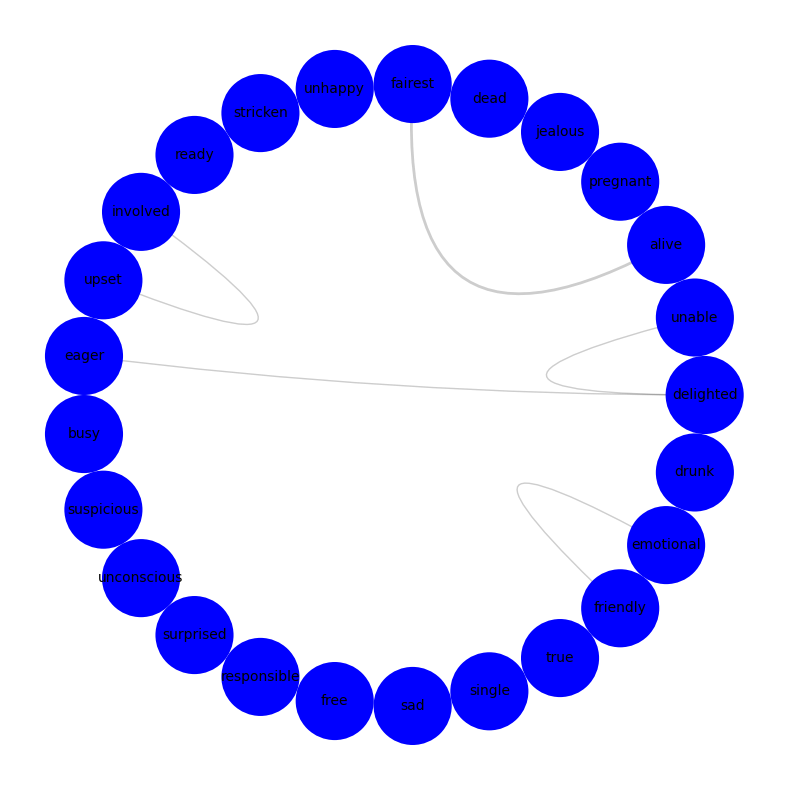

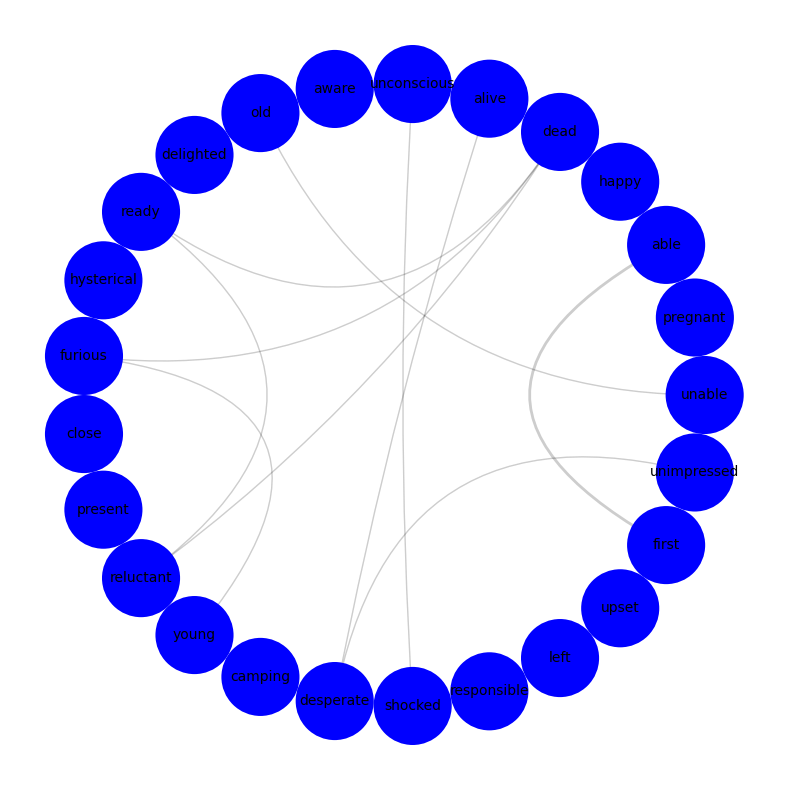

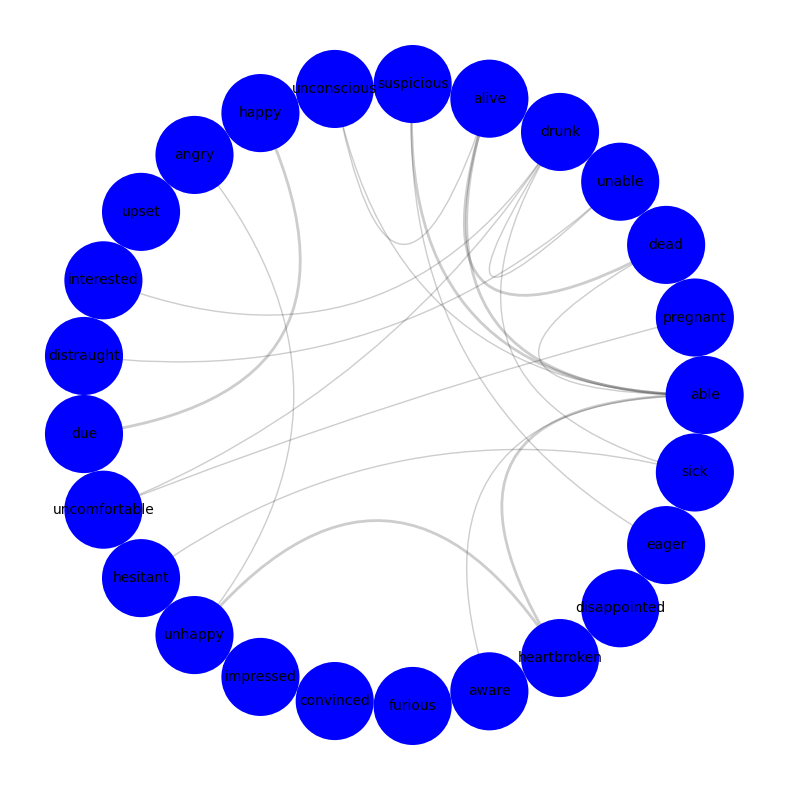

In [399]:
import networkx as nx
import nxviz as nv
from nxviz import annotate

lemma_type = 'attribute'
n_attr = 25

def create_cooc_mtx(vocab, df, lemma_type):
    vocab = [el[0] for el in vocab]
    cooc_mtx = np.zeros((len(vocab), len(vocab)))
    word2id = {word: i for i, word in enumerate(vocab)}
    id2word = {i: word for i, word in enumerate(vocab)}
    for i, row in tqdm(df.iterrows()):
        curr_attr = row[f'{lemma_type}_lemma']
        for attr1 in curr_attr:
            if attr1 not in vocab:
                continue
            for attr2 in curr_attr:
                if attr2 not in vocab or attr1 == attr2:
                    continue 
                cooc_mtx[word2id[attr1], word2id[attr2]] += 1
    return cooc_mtx, id2word

for i, decade in enumerate([1930, 1970, 2010]):
    fig = plt.figure(figsize=(10, 10))
    decade_descriptions = characters_with_description[characters_with_description['decade'] == decade]
    decade_female = decade_descriptions[decade_descriptions['gender'] == 'female']

    female_att_freqs, female_attribute_vocab = get_unique_verbs_and_freqs(decade_female[f'{lemma_type}_lemma'])
    female_coocs, id2word = create_cooc_mtx(female_att_freqs.most_common(n_attr), decade_female, lemma_type)

    female_G = nx.from_numpy_matrix(female_coocs, create_using=nx.MultiGraph)
    female_G = nx.relabel_nodes(female_G, id2word);
    
    nv.circos(female_G, edge_lw_by='weight') 
    annotate.circos_labels(female_G) 
    
